<a href="https://colab.research.google.com/github/Alvaro-Garcia-Parra/AA_GRUPO3/blob/main/AA_PRACTICA4_GRUPO3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación Dataset

El dataset seleccionado se encuentra en kaggle.com y contiene 25.000 imágenes histopatológicas con 5 clases de tipos de cáncer. Todas las imágenes tienen un tamaño de 768 x 768 píxeles y están en formato de archivo jpeg. 
Las imágenes se generaron a partir de una muestra original de fuentes validadas y compatibles con HIPAA, que consta de 750 imágenes totales de tejido pulmonar (250 tejido pulmonar benigno, 250 adenocarcinomas de pulmón y 250 carcinomas de células escamosas de pulmón) y 500 imágenes totales de tejido de colon (250 tejido benigno tejido de colon y 250 adenocarcinomas de colon) y aumentó a 25.000 usando el Augmentor paquete.

HIPPA: El cumplimiento de la Ley de Portabilidad y Responsabilidad de Seguros de Salud de los EE. UU. obliga a las empresas que tratan información médica protegida (PHI, en inglés “Protected Health Information”) a implementar y seguir medidas de seguridad físicas, para sus redes y para sus procesos.

Augmentor es un paquete de Python diseñado para ayudar al aumento y la generación artificial de datos de imágenes para tareas de aprendizaje automático. Es principalmente una herramienta de aumento de datos.

In [ ]:
# Instalación de paquetes necesarios en máquina
!pip install opendatasets
!pip install pandas

!rm -r sample_data/

In [ ]:
# Librerías
import matplotlib.pyplot as plt
import opendatasets as od
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import glob
import cv2
import os

In [ ]:
# Descargar datos de kaggle
od.download("https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images")

# username: anaalonsocaizares
# key: 8616c6bfea0024017a8e3d5805d05ad6

## Preparación de los datos e hiperparámetros

La numeración de clases que utilizaremos será:
- Clase 1: Adenocarcinoma pulmonar
- Clase 2: Tejido benigno pulmonar
- Clase 3: Carcinoma de células escamosas pulmonar
- Clase 4: Adenocarcinoma colón
- Clase 5: Tejido benigno colón

In [ ]:
# Definimos variables que van a contener los resultados de los entrenamientos
HISTORY = []
TEST_LOSS = []
TEST_ACCURACY = []

# Hiperparámetros
DATASET_SIZE = 25000
IMG_WIDTH = 128
IMG_HEIGHT = 128
VAL_SPLIT = 0.2                             # Para validación utilizaremos 1000 imágenes de cada clase
BUFFER_SIZE = int(DATASET_SIZE * VAL_SPLIT) # El tamaño de la partición train-validation
BATCH_SIZE = 250
EPOCHS = 20

Hay un total de 25000 imágenes, de las cuáles 24500 serán para entrenamiento, y de esa cantidad, se dejarán 5000 para validación (mil de cada clase) y 500 serán para test.
Por otro lado, se crea crean las etiquetas con cada foto correspondiente y se reorganizan de nuevo aleatoriamente para mezclar los cinco tipos de clase.

In [ ]:
PATH = "lung-and-colon-cancer-histopathological-images/lung_colon_image_set"

train_files = []
val_files = []
test_files = []
train_labels = []
val_labels = []
test_labels = []

label = np.zeros(5)

for i,clase in enumerate(['lung_aca/', 'lung_n/', 'lung_scc/', 'colon_aca/', 'colon_n/']):
  files = glob.glob(f'{PATH}/*/{clase}/*.jpeg') # Recopilar todos los archivos jpeg
  l = label.copy() # Crear una copia de label para construir etiquetas
  l[i] = 1 # Posición correspondiente a la clase
  random.shuffle(files) # Reorganizar aleatoriamente la lista
  test_files += files[:100]
  val_files += files[100:1100]
  train_files += files[1100:]
  test_labels += [l] * 100
  val_labels += [l] * 1000
  train_labels += [l] * 3900

print(f'TRAIN: {len(train_files)}, {len(train_labels)}')
print(f'VALIDATION: {len(val_files)}, {len(val_labels)}')
print(f'TEST: {len(test_files)}, {len(test_labels)}')
print(train_files[10000])
print(train_labels[10000])

Para un buen procesamiento de datos utilizamos una función de preprocesamiento, resize, que cambia el tamaño de las imágenes a 128x128 en vez de los 768x768 iniciales, porque sino su tamaño es demasiado grande y el tiempo de ejecución es mayor. Además se normalizan los píxeles de las imágenes en un rango de [-1,1].

In [ ]:
# Funciones para cargar imágenes
def load_img(file):
  img = tf.image.decode_jpeg(tf.io.read_file(file))
  img = tf.cast(img, dtype=tf.float32) # Convertir img a tipo float32
  img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH]) # Resize
  img = img/127.5 - 1 # Normalizar píxeles al rango [-1,1]
  return img

def load_train_data(file, label):
  return load_img(file), label

In [ ]:
img = load_img(train_files[0])
plt.imshow(img)
print(img.shape)
print(train_files[0])
print(train_labels[0])

Se observa que el color cambia, sin embargo esto es debido a la function `plt.imshow()`. Si deshacemos la normalización devolviendo los valores de los pixeles a [0,255] y convertimos el tipo de dato a entero:

In [ ]:
img = load_img(train_files[0])
img = (img+1) * 127.5
plt.imshow(tf.cast(img, tf.int32))

In [ ]:
# Creación de objeto tf.dataset para entrenamiento
train_dataset = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset = train_dataset.map(load_train_data, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

# tf.dataset para validación
val_dataset = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_dataset = val_dataset.map(load_train_data, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(1)

# tf.dataset para test
test_dataset = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
test_dataset = test_dataset.map(load_train_data, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(1)


# Modelos

In [ ]:
# Librerías
from keras import models
from keras import layers

## Modelo 1

In [ ]:
# CONSTRUIMOS LA ARQUITECTURA DE LA RED
network = models.Sequential()
network.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
network.add(layers.MaxPooling2D((2, 2)))
network.add(layers.Conv2D(64, (3, 3), activation='relu'))
network.add(layers.MaxPooling2D((2, 2)))
network.add(layers.Conv2D(64, (3, 3), activation='relu'))
network.add(layers.MaxPooling2D((2, 2)))
network.add(layers.Conv2D(128, (3, 3), activation='relu'))
network.add(layers.MaxPooling2D((2, 2)))
network.add(layers.Flatten())
network.add(layers.Dense(512, activation = 'relu'))
network.add(layers.Dense(256, activation = 'relu'))
network.add(layers.Dense(256, activation = 'relu'))
network.add(layers.Dense(5, activation = 'softmax'))

network.summary()

En este primer modelo, en la capa convolucional obtenemos 896 parámetros, siendo el tamaño de la ventana 3, filtros aplicados 32 y el umbral 1. Además debemos tener en cuenta que el tensor es de dimensión 3 porque las imágenes son a color por tanto las 3 capas de RGB. Los cálculos quedarían ((3x3)x3 +1))x32. Tras esta capa las nuevas matrices son de 126x126.

Las matrices de ser 128x128 pasan a ser de 126x126 porque 128-3+1.

A continuación, realizamos las operaciones de pooling con un tamaño de ventana de 2 obteniendo así matrices de 63x63 para los datos de entrada de la segunda capa. 

Los tamaños de ventana para las operaciones de convolucional y maxpooling son los mismos para todo el modelo.

En esta segunda capa convolucional obtenemos 18496 parámetros, las matrices tienen dimensión de 61x61 y aplicando 64 filtros, quedaría ((3x3x32)+1)x64, es decir lo anterior más los nuevos filtros.

De nuevo realizamos maxpooling y obtenemos  matrices de 30x30. Se vuelve a poner otra capa convolucional y obtenemos un total de 36928 parámetros, las matrices tienen dimensión de 28x28 (30-3+1), la operación resultaría ((3x3x64)+1)x64. Ahora maxpooling y las matrices pasan a ser de dimensión 14x14.

Se repite de nuevo con otras dos capas, una de convolución y otra de maxpooling, esto es que las matrices son de dimensión 12x12 ya que (14-3+1) y aplicando 128 filtros, obtenemos un total de parámetros de 73856 debido a ((3x3x64)+1)x128. Y tras el maxpooling quedan matrices de 6x6.

Se añade una capa flatten para ajustar los tensores a la entrada de varias capas densas , es decir aplanamos, pasando de un tensor 3D a 1D, con 6x6x128 = 4608. Ahora, las 3 capas densas de 512 neuronas, 256 y otras 256 antes de la salida. Estas tienen función de activación relu y los parámetros son 2359808 (4608 parámetros *512 neuronas) +512 de sus respectivos umbrales; a continuación la siguiente capa densa de 256 neuronas es (256x512)+256= 131328 parámetros; por último son 65792 parámetros debido a (256x256)+256, que es 256 de la capa que estamos implementando más las 256 anteriores y sus respectivos umbrales.


Por último, una capa densa de 5 neuronas, ya que estamos clasificando por los distintos tipos de cáncer que son cinco, más sus umbrales (5*256)+5 se obtienen 1285 parámetros. Es en está última capa donde cambiamos la función de activación de 'relu' a 'softmax', ya que queremos que la salida del modelo sea in vector que contenga una distribución de probabilidades de los 5 tipos de cáncer que hay para clasificar.  

Además, haciendo la suma de todos los parámetros, se obtienen los 2,688,389 parámetros totales (todos ellos entrenables).

## Modelo 2

In [ ]:
# CONSTRUIMOS LA ARQUITECTURA DE LA RED
network2 = models.Sequential()
network2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3), padding='same'))
network2.add(layers.MaxPooling2D((2, 2)))
network2.add(layers.BatchNormalization())
network2.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
network2.add(layers.MaxPooling2D((2, 2)))
network2.add(layers.BatchNormalization())
network2.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
network2.add(layers.MaxPooling2D((2, 2)))
network2.add(layers.BatchNormalization())
network2.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
network2.add(layers.MaxPooling2D((2, 2)))
network2.add(layers.BatchNormalization())
network2.add(layers.Flatten())
network2.add(layers.Dropout(0.5))
network2.add(layers.Dense(512, activation = 'relu'))
network2.add(layers.Dropout(0.5))
network2.add(layers.Dense(256, activation = 'relu'))
network2.add(layers.Dropout(0.5))
network2.add(layers.Dense(256, activation = 'relu'))
network2.add(layers.Dense(5, activation = 'softmax'))

network2.summary()

En este segundo modelo, para el cálculo de los parámetros, así como los tamaños de las matrices tras las operaciones convolucionales y de maxpooling se procede de la misma manera.

Por otro lado, la diferencia con el primer modelo es la introducción de los métodos de batchnormalization y dropout. Ambos métodos se utilizan para evitar el overfitting. 

El método de batchnormalization consiste en la normalización de capas por lotes realizando una transformación que mantiene la media cercana a cero y la desviación estándar cercana a uno. Es importante destacar que funciona de diferente manera durante el entrenamiento y durante la validación. Durante el entrenamiento la capa se normaliza en base a la media y desviación del lote actual de entradas, en cambio en la validación utiliza la media y desviación estándar móvil de los lotes vistos durante el entrenamiento.

El dropout es una de las técnicas de regularización más efectivas que al aplicar a una capa pone a cero aletoriamente un número de características, que dependerá de la tasa que se ponga, en la capa de salida durante el entrenamiento.

Aplicando estas dos técnicas el objetivo es conseguir un modelo más óptimo que el primero.

En este nuevo modelo se han hecho muchas pruebas introduciendo estos dos métodos en distintas capas, probando a quitarlos en otras, modificando la tasa de dropout haciendo variaciones entre 0.2 y 0.5 y el modelo que resultó finalmente con mejores resultados es el que se muestra.  

## Modelo 3

In [ ]:
# Modelo 3
# CONSTRUIMOS LA ARQUITECTURA DE LA RED
network3 = models.Sequential()

network3.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3), padding='same'))
network3.add(layers.MaxPooling2D((2, 2)))

network3.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
network3.add(layers.MaxPooling2D((2, 2)))

network3.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
network3.add(layers.MaxPooling2D((2, 2)))

network3.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
network3.add(layers.MaxPooling2D((2, 2)))

network3.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
network3.add(layers.MaxPooling2D((2, 2)))

network3.add(layers.Flatten())
network3.add(layers.Dense(512, activation = 'relu'))
network3.add(layers.Dropout(0.5))

network3.add(layers.Dense(5, activation = 'softmax'))

network3.summary()

Configuramos otro modelo más para seguir optimizándolo. En base a prueba y error, se han ido probando dónde es más efectiva la técnica del dropout. 

# Entrenamientos

## Entrenamiento modelo 1

In [ ]:
network.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = network.fit(train_dataset,
                      epochs = EPOCHS,
                      validation_data = val_dataset) # Validation accuracy = 81%
HISTORY.append(history)

Epoch 1/20
78/78 [==============================] - 120s 1s/step - loss: 0.9140 - accuracy: 0.6663 - val_loss: 0.8230 - val_accuracy: 0.6166
Epoch 2/20
78/78 [==============================] - 110s 1s/step - loss: 0.7384 - accuracy: 0.6650 - val_loss: 0.6783 - val_accuracy: 0.5962
Epoch 3/20
78/78 [==============================] - 110s 1s/step - loss: 0.7152 - accuracy: 0.6398 - val_loss: 0.6792 - val_accuracy: 0.5998
Epoch 4/20
78/78 [==============================] - 109s 1s/step - loss: 0.6807 - accuracy: 0.6574 - val_loss: 0.6480 - val_accuracy: 0.6106
Epoch 5/20
78/78 [==============================] - 111s 1s/step - loss: 0.6176 - accuracy: 0.6716 - val_loss: 0.6940 - val_accuracy: 0.6008
Epoch 6/20
78/78 [==============================] - 109s 1s/step - loss: 0.6495 - accuracy: 0.6354 - val_loss: 0.6722 - val_accuracy: 0.6070
Epoch 7/20
78/78 [==============================] - 109s 1s/step - loss: 0.6189 - accuracy: 0.7065 - val_loss: 0.6984 - val_accuracy: 0.5972
Epoch 8/20
78

En la época 18 aproximadamente es cuando alcanza la pérdida más baja a la vez que la precisión más alta, un 41% y 82% respectivamente. Esto se verá mejor en el gráfico que mostraremos a continuación, para ver la pérdida tanto en el entrenamiento como en la validación.

In [ ]:
# VERIFICAMOS NUESTRO MODELO YA ENTRENADO, CONTRA EL CONJUNTO DE PRUEBAS
print("\nModelo 1:")
M1_test_loss, M1_test_acc = network.evaluate(test_dataset)
TEST_LOSS.append(M1_test_loss)
TEST_ACCURACY.append(M1_test_acc)
print('test_loss:', M1_test_loss)
print('test_acc:', M1_test_acc)


Modelo 1:
500/500 [==============================] - 3s 3ms/step - loss: 0.4423 - accuracy: 0.7740
test_loss: 0.44227251410484314
test_acc: 0.7739999890327454


Los resultados obtenidos no son muy óptimos puesto que la pérdida esta en más de un 50% cuando predice nuevas imágenes y la precisión es de tan solo un 70%. Se configurarán nuevos modelos aplicando otras técnicas y modificando hiperparámetros para conseguir mejoras.

500/500 [==============================] - 3s 2ms/step
=VALORES QUE PREDICE EL MODELO ENTRENADO CON LAS IMAGENES DE TEST======
=IMAGEN VERDADERA:=======================
[1. 0. 0. 0. 0.]
=PREDICCIÓN:=======================
[0.42504215 0.00326179 0.48751834 0.0808671  0.00331062]


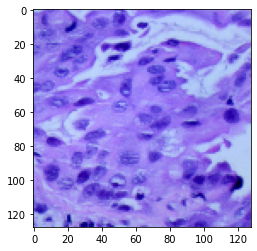

In [ ]:
# Predict
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

# Predicción de valores desde el dataset de validación
Y_pred = network.predict(test_dataset)
print("=VALORES QUE PREDICE EL MODELO ENTRENADO CON LAS IMAGENES DE TEST======")
print("=IMAGEN VERDADERA:=======================")
print(test_labels[1])
img = load_img(test_files[1])
img = (img+1) * 127.5
plt.imshow(tf.cast(img, tf.int32))
print("=PREDICCIÓN:=======================")
print(Y_pred[1])
print("=======================================================================")

Con esto podemos comprobar que la etiqueta de esta imagen corresponde al cáncer de tipo uno, es decir, adenocarcinoma pulmonar y en la predicción el valor más alto esta en la tercera posición lo que quiere decir que lo predice como si fuera carcinoma de células escamosas pulmonar. El siguiente valor más alto si es el real, pero por ahora es una mala predicción porque confunde esos dos.

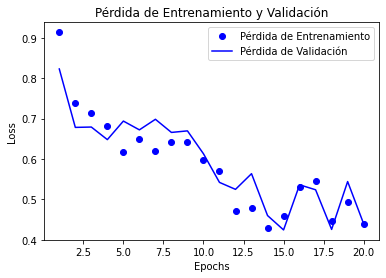

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, EPOCHS + 1)

# Gráfico pérdida frente a las epochs
# "bo" es para "punto azun"
plt.plot(epochs, loss, 'bo', label='Pérdida de Entrenamiento')
# "b" es para "linea continua azul"
plt.plot(epochs, val_loss, 'b', label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Como ya se mencionó anteriormente, el punto más bajo es entorno a la época 18 aunque se produce sobreentrenamiento en épocas anteriores.

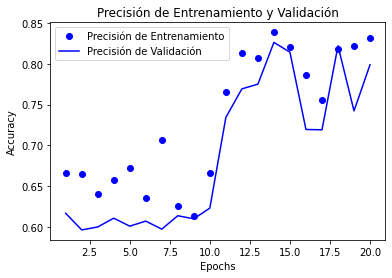

In [ ]:
plt.clf()   # Limpia la figura
# Gráfico precisión frente a las epochs
# "bo" es para "punto azun"
plt.plot(epochs, acc, 'bo', label='Precisión de Entrenamiento')
# "b" es para "linea continua azul"
plt.plot(epochs, val_acc, 'b', label='Precisión de Validación')
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Aquí se vuelve a ver un comportamiento irregular, dónde se dispara y vuelve a bajar la precisión. 

## Entrenamiento modelo 2 - Regularizador dropout

In [ ]:
network2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history2 = network2.fit(train_dataset,
                      epochs = EPOCHS,
                      validation_data = val_dataset)
HISTORY.append(history2)

Epoch 1/20
78/78 [==============================] - 113s 1s/step - loss: 1.0504 - accuracy: 0.7557 - val_loss: 5.3205 - val_accuracy: 0.2000
Epoch 2/20
78/78 [==============================] - 111s 1s/step - loss: 0.9193 - accuracy: 0.7370 - val_loss: 4.9237 - val_accuracy: 0.2038
Epoch 3/20
78/78 [==============================] - 110s 1s/step - loss: 0.9620 - accuracy: 0.7272 - val_loss: 2.6599 - val_accuracy: 0.2910
Epoch 4/20
78/78 [==============================] - 109s 1s/step - loss: 0.8674 - accuracy: 0.7340 - val_loss: 5.1877 - val_accuracy: 0.2664
Epoch 5/20
78/78 [==============================] - 110s 1s/step - loss: 0.9107 - accuracy: 0.7102 - val_loss: 3.0393 - val_accuracy: 0.3810
Epoch 6/20
78/78 [==============================] - 111s 1s/step - loss: 0.8842 - accuracy: 0.7420 - val_loss: 1.9396 - val_accuracy: 0.6122
Epoch 7/20
78/78 [==============================] - 110s 1s/step - loss: 0.8304 - accuracy: 0.7193 - val_loss: 2.4772 - val_accuracy: 0.5824
Epoch 8/20
78

In [ ]:
print("\nModelo 2:")
M2_test_loss, M2_test_acc = network2.evaluate(test_dataset)
TEST_LOSS.append(M2_test_loss)
TEST_ACCURACY.append(M2_test_acc)
print('test_loss:', M2_test_loss)
print('test_acc:', M2_test_acc)


Modelo 2:
500/500 [==============================] - 3s 3ms/step - loss: 1.5978 - accuracy: 0.6060
test_loss: 1.597780466079712
test_acc: 0.6060000061988831


500/500 [==============================] - 3s 2ms/step
=VALORES QUE PREDICE EL MODELO ENTRENADO CON LAS IMAGENES DE TEST======
=IMAGEN VERDADERA:=======================
[1. 0. 0. 0. 0.]
=PREDICCIÓN:=======================
[0.00624666 0.9195787  0.00153445 0.05575575 0.01688463]


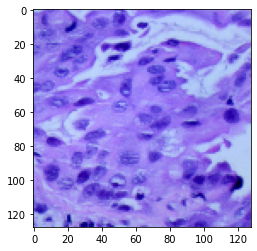

In [ ]:
# Predicción de valores desde el dataset de validación
Y_pred = network2.predict(test_dataset)
print("=VALORES QUE PREDICE EL MODELO ENTRENADO CON LAS IMAGENES DE TEST======")
print("=IMAGEN VERDADERA:=======================")
print(test_labels[1])
img = load_img(test_files[1])
img = (img+1) * 127.5
plt.imshow(tf.cast(img, tf.int32))
print("=PREDICCIÓN:=======================")
print(Y_pred[1])
print("=======================================================================")

De nuevo vemos como predice este nuevo modelo la misma imagen que en el modelo uno. En este caso, predice que es un tipo dos, es decir un tejido benigno pulmonar y la probabilidad de que corresponda al real esta en la cuarta posición ordenándolas.

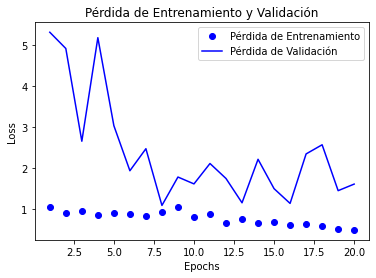

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Gráfico pérdida frente a las epochs
# "bo" es para "punto azun"
plt.plot(epochs, loss, 'bo', label='Pérdida de Entrenamiento')
# "b" es para "linea continua azul"
plt.plot(epochs, val_loss, 'b', label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

En esta gráfica, se observa que entorno a la época 6 se dispara la pérdida y hay un sobreajuste pero luego vuelve a seguir disminuyendo y alcanza más precisión y baja pérdida en la época 10/11.

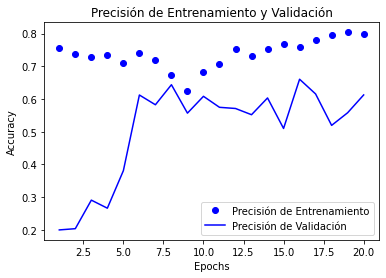

In [ ]:
plt.clf()   # Limpia la figura
# Gráfico precisión frente a las epochs
# "bo" es para "punto azun"
plt.plot(epochs, acc, 'bo', label='Precisión de Entrenamiento')
# "b" es para "linea continua azul"
plt.plot(epochs, val_acc, 'b', label='Precisión de Validación')
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Entrenamiento modelo 3 - Modificación modelo 2

In [ ]:
network3.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history3 = network3.fit(train_dataset,
                      epochs = EPOCHS,
                      validation_data = val_dataset)
HISTORY.append(history3)

Epoch 1/20
78/78 [==============================] - ETA: 0s - loss: 1.0166 - accuracy: 0.6215

KeyboardInterrupt: ignored

In [ ]:
# VERIFICAMOS NUESTRO MODELO YA ENTRENADO, CONTRA EL CONJUNTO DE PRUEBAS
print("\nModelo 3:")
M3_test_loss, M3_test_acc = network3.evaluate(test_dataset)
TEST_LOSS.append(M3_test_loss)
TEST_ACCURACY.append(M3_test_acc)
print('test_loss:', M3_test_loss)
print('test_acc:', M3_test_acc)

In [ ]:
# Predicción de valores desde el dataset de validación
Y_pred = network3.predict(test_dataset)
print("=VALORES QUE PREDICE EL MODELO ENTRENADO CON LAS IMAGENES DE TEST======")
print("=IMAGEN VERDADERA:=======================")
print(test_labels[1])
img = load_img(test_files[1])
img = (img+1) * 127.5
plt.imshow(tf.cast(img, tf.int32))
print("=PREDICCIÓN:=======================")
print(Y_pred[1])
print("=======================================================================")

Al igual que en el modelo uno, confunde la clase cuatro, adenocarcinoma colon con adenocarcinoma pulmonar que es la clase 1, es decir la etiqueta verdadera.

In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1, EPOCHS + 1)

# Gráfico pérdida frente a las epochs
# "bo" es para "punto azun"
plt.plot(epochs, loss, 'bo', label='Pérdida de Entrenamiento')
# "b" es para "linea continua azul"
plt.plot(epochs, val_loss, 'b', label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # Limpia la figura
# Gráfico precisión frente a las epochs
# "bo" es para "punto azun"
plt.plot(epochs, acc, 'bo', label='Precisión de Entrenamiento')
# "b" es para "linea continua azul"
plt.plot(epochs, val_acc, 'b', label='Precisión de Validación')
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Resultados

In [ ]:
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

## Curvas de aprendizaje

In [ ]:
# Curvas de aprendizaje
"""
Notas: Los elementos de HISTORY son diccionarios que contienen los nombres de las métricas como claves 
y sus valores (.values()) son listas con los valores de las métricas durante el entrenamiento model.fit
"""
def curvas_aprendizaje(HISTORY, nfilas, ncol, size = (18,10), title = []):
    # Función para imprimir las curvas de aprendizaje en una rejilla de nfilas x ncol
    # Argumentos: HISTORY = Lista con variables history de keras (obtenidas de model.fit)
    #        nfilas, ncol = Nº de filas y columnas de la rejilla
    #                size = Tamaño total de la rejilla (por defecto es (18,10))
    # !Importante: El nº total de filas x col debe ser superiror al de los elementos pasados como argumento en HISTORY
    if len(HISTORY) > nfilas*ncol:
        print("Error. Dimensiones incompatibles")
        return 0
    else:
        fig = plt.figure(figsize=size) # Especifica tamaño de la figura

        for i, registro in enumerate(HISTORY):

            plt.subplot(nfilas, ncol, i+1) # Añade subplot (gráfica para un modelo)
            if title:
              plt.title(title[i])
            else:
              plt.title("Modelo " + str(i+1)) # Formato de cada gráfica
            plt.xlabel('Épocas')
            plt.ylim((0,2))

            acc = registro.history['accuracy']
            loss = registro.history['loss']

            x = list(range(1, len(acc) + 1))

            plt.plot(x,loss, 'o-') # Imprime 
            plt.plot(x, acc, 'o-')

            plt.xticks(x)
            plt.legend(list(registro.history.keys()))
            plt.text(len(x), loss[len(loss)-1], str(round(loss[len(loss)-1],3))) # Valor punto final  loss
            plt.text(len(x), acc[len(acc)-1], str(round(acc[len(acc)-1],3))) # Valor punto final  loss

    fig.tight_layout()
    plt.show()

In [ ]:
curvas_aprendizaje(HISTORY, 2, 2, (16,16))

## Matrices de confusión

En este apartado observamos los tipos de predicciones (correctas e incorrectas) que realizan nuestros 8 modelos distintos. Para ello, tenemos en cuenta la matriz de confusión donde podemos ver los VP (verdaderos positivos), VN (verdaderos negativos), FP (falsos positivos), FN (falsos negativos).

In [ ]:
# Matrices de confusión
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Observación')
    plt.xlabel('Predicción')

def show_confusion_matrix(predictions):
    # Predicción de valores desde el dataset de validación
    Y_pred = predictions
    # Convertir en predicciones de clases desde los vectores one-hot encoding 
    Y_pred_classes = np.argmax(Y_pred, axis = 1) 
    # Convertir en clases de observación desde los vectores one-hot encoding
    Y_true = np.argmax(test_labels, axis = 1) 
    # Computar la matriz de confusión
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    # Dibujar la matriz de confusión
    plot_confusion_matrix(confusion_mtx, classes = range(10))

In [ ]:
# Predicciones de los modelos en el conjunto de datos de entrenamiento
# cambiar
predictions1 = network.predict(test_dataset)
predictions2 = network2.predict(test_dataset) 
predictions3 = network3.predict(test_dataset)

In [ ]:
# Modelo 1
show_confusion_matrix(predictions1)

In [ ]:
# Modelo 2
show_confusion_matrix(predictions2)

In [ ]:
# Modelo 3
show_confusion_matrix(predictions3)

## Distribución de probabilidades

In [ ]:
# Prediction distributions
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)    

    predicted_label = np.argmax(predictions_array)
    if predicted_label.all() == true_label.all():
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                  100*np.max(predictions_array),
                                  true_label),
                                  color=color)


def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('black')

def show_predicted_distributions(predictions, n):
    Y_true = np.argmax(test_labels, axis = 1)
    for i in range(n):
      plt.figure(figsize=(6,3))
      plt.subplot(1,2,1)
      plot_image(i, predictions[i], Y_true, test_images.reshape(10000,28,28))
      plt.subplot(1,2,2)
      plot_value_array(i, predictions[i],  Y_true)
      plt.show()
      plt.clf()

In [ ]:
# Predicciones de las 10 primeras imagenes de test
# Modelo 1
show_predicted_distributions(predictions1, 10)

In [ ]:
# Modelo 2
show_predicted_distributions(predictions2, 10)

In [ ]:
# Modelo 3
show_predicted_distributions(predictions3, 10)

## Test error y test accuracy

In [ ]:
# Gráfico de barras horizontales
def testerror_testacc(ERROR, ACC, titles, size = (12,12)):
    fig = plt.figure(figsize=size) # Especifica tamaño de la figura

    # Ordena pérdida en orden ascendente y precisión en orden descendente
    sorted_err = dict(zip(titles, ERROR))
    sorted_err = dict(sorted(sorted_err.items(), key = lambda x: x[1], reverse=True)) 

    sorted_acc = dict(zip(titles, ACC))
    sorted_acc = dict(sorted(sorted_acc.items(), key = lambda x: x[1])) 

    # Gráfica
    plt.subplot(1, 2, 1)
    plt.barh(list(sorted_err.keys()), list(sorted_err.values()))
    plt.title('Test error')

    plt.subplot(1,2,2)
    plt.barh(list(sorted_acc.keys()), list(sorted_acc.values()), color='orange')
    plt.title('Test accuracy')

    fig.tight_layout()
    plt.show()

In [ ]:
# Gráfica de barras horizontales con los errores y accuracy de cada modelo (TEST_LOSS, TEST_ACC) 
# Crear función en apartado Funciones para graficar
title = ['Modelo ' + str(i+1) for i in range(3)]

testerror_testacc(TEST_LOSS, TEST_ACCURACY, title, (14, 5))

# Conclusiones

Realizando una comparación de modelos, el peor modelo es el segundo ya que se obtiene una pérdida de aproximadamente 2.3 y una precisión de entorno al 50%. Los modelos 1 y 3 resultan mucho más eficientes ya que la precisión ronda 80% y 75% respectivamente y la pérdida en ambas ronda entorno al 45%, un poco menos en el modelo 1 con alrededor de un 40%. Esto es debido a que diferenciar entre unos tipos de adenocarcinoma y otro es bastante complejo.


Futuras mejoras

Uno de los primeros pasos para la mejoraría de este trabajo sería investigar hasta donde se ha llegado con redes convolucionales que analicen imágenes médicas, ver que técnicas e hiperparámetros se están utilizando. En nuestro caso el mejor modelo obtenido ha sido el primero por lo que se intentará ir modificando ese modelo, probando a variar los hiperparámetros. Un inconveniente que se tendría que tener en cuenta a futuro, porque en este trabajo lo ha sido, sería la capacidad computacional, ha sido mucho el tiempo dedicado a la ejecución del código.
Otra de las líneas futuras a seguir sería realizar una investigación en profundidad sobre el uso de redes neuronales recurrentes, más en concreto del tipo LSTM
